In [27]:
from ANN import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import matplotlib.colors as mcol
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import tqdm_notebook as pbar

In [13]:
def akkuracy(model, data_x, data_y):
    # data_x and data_y are numpy array-of-arrays matrices
    X = T.Tensor(data_x).cuda()
    Y = T.ByteTensor(data_y).cuda()   # a Tensor of 0s and 1s
    oupt = model(X)            # a Tensor of floats
    pred_y = oupt >= 0.5       # a Tensor of 0s and 1s
    num_correct = T.sum(Y==pred_y)  # a Tensor
    acc = (num_correct.item() * 100.0 / len(data_y))  # scalar
    return acc

In [14]:
# io train
X = []
Y = []
with open("synthetic_dataset/train.txt") as f:
    reader = csv.reader(f)
    for row in reader:
        X.append([float(row[0]), float(row[1])])
        Y.append([int(row[2])-1])
                
# PredictorScaler=StandardScaler()
# X = PredictorScaler.fit_transform(X)
X = np.array(X, dtype=np.float64)
Y = np.array(Y, dtype=np.float64)

In [15]:
# io dev
X_dev = []
Y_dev = []
with open("synthetic_dataset/dev.txt") as f:
    reader = csv.reader(f)
    for row in reader:
        X_dev.append([float(row[0]), float(row[1])])
        Y_dev.append([int(row[2])-1])
        
# X_dev = PredictorScaler.transform(X_dev)
X_dev = np.array(X_dev, dtype=np.float64)
Y_dev = np.array(Y_dev, dtype=np.float64)

In [16]:
#creating instance of one-hot-encoder
encoder = OneHotEncoder()

# create df_Y
df_Y = pd.DataFrame(np.array(Y,dtype=int))

#perform one-hot encoding on  Y
encoder_df = pd.DataFrame(encoder.fit_transform(Y.reshape(-1,1)).toarray())
Yhat = encoder_df.to_numpy()

In [69]:
net = ANN(dataset_type='syn', args=[10,5]).to('cuda')
net = net.train()  # set training mode
lrn_rate = 1e-4
bat_size = 125
loss_func = T.nn.BCELoss().cuda()  # softmax() + binary CE
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate)
max_epochs = 40000
n_items = len(X)
batcher = Batcher(n_items, bat_size)

In [70]:
losses = []
for epoch in pbar(range(max_epochs)):
    loss = 0.
    if epoch > 0 and epoch % (10) == 0:
        print('epoch = %6d' % epoch, end='')
        print('  batch loss = %7.4f' % np.average(losses[-10:]), end='')
        acc = akkuracy(net, X, Y)
        print(' train accuracy = %0.2f' % acc, end='')
        acc = akkuracy(net, X_dev, Y_dev)
        print(' dev accuracy = %0.2f' % acc)
    for curr_bat in batcher:
        X1 = T.Tensor(X[curr_bat]).cuda()
        if(net.dataset_type == 'binary'):
            Y1 = T.Tensor(Y[curr_bat]).cuda()
        else:
            Y1 = T.LongTensor(Y[curr_bat]).cuda()
        optimizer.zero_grad()
        oupt = net(X1)
        print(oupt)
        print(Y1)
        loss_obj = loss_func(oupt, Y1)
        loss_obj.backward()
        loss += loss_obj.item()
        optimizer.step()
    # loss /= batcher.num_items
    losses.append(loss)
    if(loss < 0.001):
        break

  0%|          | 0/40000 [00:00<?, ?it/s]

epoch =     10  batch loss = 14.4903 train accuracy = 50.12 dev accuracy = 50.30
epoch =     20  batch loss = 13.9074 train accuracy = 60.08 dev accuracy = 59.50
epoch =     30  batch loss = 13.3530 train accuracy = 72.80 dev accuracy = 71.10
epoch =     40  batch loss = 12.7613 train accuracy = 76.00 dev accuracy = 74.90
epoch =     50  batch loss = 12.1444 train accuracy = 77.88 dev accuracy = 75.90
epoch =     60  batch loss = 11.5703 train accuracy = 78.48 dev accuracy = 76.70
epoch =     70  batch loss = 11.0796 train accuracy = 79.08 dev accuracy = 77.00
epoch =     80  batch loss = 10.6678 train accuracy = 79.84 dev accuracy = 78.00
epoch =     90  batch loss = 10.3161 train accuracy = 80.16 dev accuracy = 78.90
epoch =    100  batch loss =  9.9996 train accuracy = 80.92 dev accuracy = 80.00
epoch =    110  batch loss =  9.6980 train accuracy = 81.64 dev accuracy = 80.30
epoch =    120  batch loss =  9.4007 train accuracy = 82.04 dev accuracy = 80.70
epoch =    130  batch loss =

In [71]:
def plot_decision_boundary(X, y,X_orig, model, steps=1000, cmap='Paired'):
    cmap = plt.get_cmap(cmap)

    # Define region of interest by data limits
    xmin, xmax = X_orig[:,0].min() - 1, X_orig[:,0].max() + 1
    ymin, ymax = X_orig[:,1].min() - 1, X_orig[:,1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    # xx = PredictorScaler.transform(xx)
    # yy = PredictorScaler.transform(yy)
    # t = PredictorScaler.transform(np.c_[xx.ravel(), yy.ravel()])
    t = np.c_[xx.ravel(), yy.ravel()]
    labels = model.forward(T.Tensor(t).cuda()).cpu().detach().numpy()

    # hard labels
    labels_h_ind_1 = np.where(labels > 0.5)
    labels_h_ind_0 = np.where(labels <= 0.5)
    labels_h = np.zeros(labels.shape)
    labels_h[labels_h_ind_1] = 1
    labels_h[labels_h_ind_0] = 0

    # Plot decision boundary in region of interest
    z = labels_h.reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.5)

    # Get predicted labels on training data and plot
    # train_labels = model.predict(X)
    ax.scatter(X_orig[:,0], X_orig[:,1], c=y, cmap=cmap, lw=0)

    return fig, ax

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

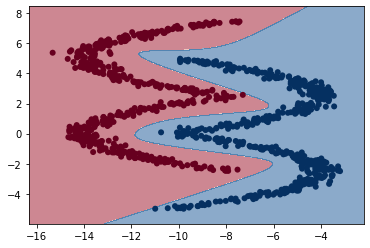

In [72]:
# X_dev_orig = PredictorScaler.inverse_transform(X_dev)
plot_decision_boundary(X_dev, Y_dev,X_dev, net, cmap='RdBu')